## Testing algorithms for tweet_data class.

In [30]:
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import pandas as pd
import collections
import scipy.stats as stats
pd.set_option("display.precision", 3)
pd.set_option("display.max_rows", 25)
pd.set_option("display.expand_frame_repr", False)

def make_partition_and_score(df_results,test_random_graph=False,pass_weights=True,verbose=False):
    G=nx.Graph()
    names=list(set(df_results['name1']))
    # randomise order of results
    df_results=df_results.sample(frac=1)
    #print(df_results.loc[:20,['p-value','Z-score','name1','name2']])
    #for result in results:
    #    edge_weight=result['p-value']
    #    node1=result['node1']
    #    node2=result['node2']
    G.add_nodes_from(list(set(df_results['object1'])))
    if test_random_graph:
        print("Testing random graph")
        G.add_edges_from([(df_results.loc[i]['object1'],df_results.loc[i]['object2']) 
                      for i in df_results.index if np.random.random()<0.5])
   
    elif pass_weights:
        G.add_edges_from([(df_results.loc[i]['object1'],df_results.loc[i]['object2'],{'weight': df_results.loc[i]['p-value']}) 
                      for i in df_results.index])
        print("Passing p-values as weights for each edge")
    else:
        G.add_edges_from([(df_results.loc[i]['object1'],df_results.loc[i]['object2'])
                         for i in df_results.index if np.random.random()<df_results.loc[i]['p-value']])
        print("Assigning each edge with probability given by its p-value")
    # if np.random.random()<df_results.loc[i]['p-value']])
    #pos = nx.spring_layout(G)
    #nx.draw_networkx_nodes(G,pos)
    #nx.draw_networkx_edges(G,pos)
    # compute the best partition
    partition = community_louvain.best_partition(G,weight='weight',resolution = 1)
    clusters=len(set(partition.values()))
    print("Divided into {0} clusters".format(clusters))
    TP=collections.defaultdict(int)
    tp=0
    FP=collections.defaultdict(int)
    fp=0
    FN=collections.defaultdict(int)
    fn=0
    for index in df_results.index:
        obj1=df_results.loc[index]['object1']
        pop1=obj1.event_t_series
        obj2=df_results.loc[index]['object2']
        pop2=obj2.event_t_series
        if pop1==pop2:
            if partition[obj1]==partition[obj2]:
                TP[obj1.name]+=1 # true positive
                tp+=1
            else:
                FN[obj1.name]+=1 # false negative
                fn+=1
        elif partition[obj1]==partition[obj2]:
                FP[obj1.name]+=1 # false positive - not interested in true negatives
                FP[obj2.name]+=1 # NB false positive edges double counted, once for each node (population object)
                fp+=1
    
    FP_overall=sum([FP[name] for name in names])/2 # halved as double counted within populations
    TP_overall=sum([TP[name] for name in names])
    FN_overall=sum([FN[name] for name in names])
    assert FP_overall==fp
    assert TP_overall==tp
    assert FN_overall==fn
    
    recalls = {name :TP[name]/(TP[name]+FP[name]) for name in names}
    #print(recalls)
    precisions = {name : TP[name]/(TP[name]+FN[name]) for name in names}
    f_scores={name : 2*recalls[name]*precisions[name]/(recalls[name]+precisions[name]) for name in names}
    print(pd.DataFrame([recalls,precisions,f_scores],index=['Recall','Precison','F-score'],columns=[name for name in names]))
    R=TP_overall/(FP_overall+TP_overall)
    P=TP_overall/(TP_overall+FN_overall)
    f_score=2*R*P/(R+P)            
    return f_score

def analyse_raw_results_for_scoring(td_object,test_random_graph=False,repeats=1,pass_weights=True,verbose=False):
    raw_results=td_object.raw_results#[:400]
    df_all = pd.DataFrame(raw_results,columns=['Z-score','object1','object2'])    
    # remove infinite/nan values
    df_all = df_all.replace(np.inf,np.nan)
    df_all=df_all.dropna(inplace=False)    
    # find p-values for each z-score
    df_all['p-value']=df_all['Z-score'].map(lambda x: stats.norm.cdf(x))
    
    # Extract the population name for each time series object
    df_all['name1']=[d.name for d in df_all['object1']]
    df_all['name2']=[d.name for d in df_all['object2']]
    names=np.sort(list(set(df_all['name1']).union(set(df_all['name2']))))
    
    df=df_all.loc[:,['p-value','Z-score','name1','name2']]
#    print(df.head(10))
    #grouped=df.groupby(['name1','name2'],as_index=False)
    #print([(name,grouped.get_group((name,name))['Z-score'].mean()) for name in set(df['name1'])])
    #grouped_again.get_group('Luke')
    #print(grouped["Z-score"].sum())
        
    
    # create a group for each population
    df_matching=df.loc[df['name1'] == df['name2']]
    grouped_matching=df_matching.groupby(['name1'],as_index=False)
    df_new=pd.DataFrame()
    for group,frame in grouped_matching:
        #df_new.loc['p-value',group]=frame['p-value'].mean()
        #df_new.loc['Z-score',group]=frame['Z-score'].mean()
        df_new[group]=frame.mean()
    
    # store non-matching population results in a separate df
    df_non_matching=df.drop(labels=df_matching.index)   
    names_dict={name:i for i,name in enumerate(names)} # random order for names
    #print(names_dict)
    swap_dict=collections.defaultdict(int)
    for i in df_non_matching.index:
        name1=df_non_matching.loc[i]['name1']
        name2=df_non_matching.loc[i]['name2']
        if names_dict[name1]>names_dict[name2]:
            #swap names so that, for any pair, the order of names is always the same
            swap_dict[name1]+=1
            df_non_matching.at[i,'name1']=name2
            df_non_matching.at[i,'name2']=name1
    # group by both names
    group_non_matching=df_non_matching.groupby(['name1','name2'],as_index=False)
    if verbose:
        assert(len(group_non_matching)==len(names)*(len(names)-1)/2)
    df_non_matching_mean=pd.DataFrame()
    for group,frame in group_non_matching:
        
        #print(group)
        #df_non_matching_mean.loc['p-value',group]=frame['p-value'].mean()
        #df_non_matching_mean.loc['Z-score',group]=frame['Z-score'].mean()
        df_non_matching_mean[group]=frame.mean()
    
    
    print("Z score and corresponding p-value mean results within each population")
    print(df_new.head(2))
    print("Z score and corresponding p-value mean results across populations")
    print(df_non_matching_mean.head(2))
    
    print("Mean non-matching Z-score is {0}".format(np.mean(df_non_matching['Z-score'])))
    print("Overall mean Z-score is {0}".format(np.mean(df_all['Z-score'])))
    scores=[]
    j=0
    #df_all=df_all.sample(frac=1)
    for i in range(repeats):
        if repeats%(int(repeats/100+1)):
            print("{0}%".format(j),end=',')
            j+=1
        print("\n")
        scores.append(make_partition_and_score(df_all,test_random_graph=test_random_graph,pass_weights=pass_weights,verbose=verbose))
    if repeats:
        print("Over {0} runs of graph and partition, mean/std score is {1}/{2}".format(repeats,np.mean(scores),np.std(scores)))
    
analyse_raw_results_for_scoring(td_to_store,repeats=0,test_random_graph=False,pass_weights=True,verbose=True)
    


Z score and corresponding p-value mean results within each population
             0      1      2      3      4      5     6      7      8      9
p-value  0.997  0.999  0.983  1.000  0.867  0.997  1.00  0.671  1.000  0.719
Z-score  3.830  4.100  2.991  9.797  1.518  3.531  8.59  0.595  5.488  0.779
Z score and corresponding p-value mean results across populations
         (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  (0, 9)  (1, 2)  ...  (5, 6)  (5, 7)  (5, 8)  (5, 9)  (6, 7)  (6, 8)  (6, 9)  (7, 8)  (7, 9)  (8, 9)
p-value   0.433   0.628   0.627   0.522   0.705   0.680   0.466   0.250   0.625   0.384  ...   0.529   0.466   0.321   0.473   0.510   0.462   0.502   0.443   0.534   0.482
Z-score  -0.235   0.448   0.461   0.100   0.721   0.615  -0.114  -0.905   0.440  -0.397  ...   0.152  -0.108  -0.709  -0.093   0.013  -0.122   0.045  -0.198   0.114  -0.039

[2 rows x 45 columns]
Mean non-matching Z-score is -0.03535435706878869
Overall mean Z-score is 0.380219170992199

In [2]:
import pandas as pd
import scipy.stats as stats
pd.set_option("display.precision", 3)
pd.set_option("display.max_rows", 25)
pd.set_option("display.expand_frame_repr", False)

def analyse_raw_results(td_object):
    raw_results=td_object.raw_results
    df_all = pd.DataFrame(raw_results,columns=['Z-score','object1','object2'])
    
    # remove infinite/nan values
    df_all = df_all.replace(np.inf,np.nan)
    print("Full index length is {0}".format(len(df_all.index)))
#    #print(df_all.head(10))
#    #removed_indices=df_all.dropna(inplace=False)
    df_all=df_all.dropna(inplace=False)
#    #print(df_all.head(10))
    print("{0} indices left after dropna".format(len(df_all.index)))
    
    # find p-values for each z-score
    df_all['p-value']=df_all['Z-score'].map(lambda x: stats.norm.cdf(x))
    
    # Extract the names of each time series object
    df_all['name1']=[d.name for d in df_all['object1']]
    df_all['name2']=[d.name for d in df_all['object2']]
    names=list(set(df_all['name1']))
    

    df=df_all.loc[:,['p-value','Z-score','name1','name2']]
    print(df.head(10))
    #grouped=df.groupby(['name1','name2'],as_index=False)
    #print([(name,grouped.get_group((name,name))['Z-score'].mean()) for name in set(df['name1'])])
    #grouped_again.get_group('Luke')
    #print(grouped["Z-score"].sum())
    
    # create a group for each population
    df_matching=df.loc[df['name1'] == df['name2']]
    grouped_matching=df_matching.groupby(['name1'],as_index=False)
    # store non-matching population results in a separate df
    df_non_matching=df.drop(labels=df_matching.index)
    df_new=pd.DataFrame()
    for group,frame in grouped_matching:
        #print(frame['Z-score'].mean())
        df_new[group]=frame.mean()
    print("Z score mean results for each population")
    print(df_new.head(2))
    print("Mean non-matching score is {0}".format(np.mean(df_non_matching['Z-score'])))
    print("Overall mean score is {0}".format(np.mean(df_all['Z-score'])))


Algorithm below initialises dense time series for correlation testing.  If 'use fixed means for setup' is True then the two populations created have expected proportions of entries given by the 'means' dictionary list.  Otherwise each time series within both populations has an expected proportion of entries given by a random selection from a truncated chai-squared distribution.  If poisson_process is true then a poisson process is used to initialise.
The two populations of time series are returned in an array; the known probability from which each individual time series was drawn are stored are also returned as an array 

In [3]:
import time
import numpy as np
import poisson_processes as pp
import pointwise_correlation as pc

def initialise_time_series_matrices(length,number,use_fixed_means_for_setup=True,means=[0.01,0.2],\
                                    poisson_process=False,multiple_populations=False,multiple_pop_params={},verbose=True):
    T=length
    chi_scaling = np.log(10)/np.log(T)
    n=number
    #means_range = max(np.abs(means[0]-means[1]),0.1)
    #means_mean =(means[0]+means[1])/2
    if verbose:
        print("Now initialising externally")
    if use_fixed_means_for_setup:
        print("Initialising with fixed means")
        known_probs_array = [[p for i in range(n)] for p in means]
    else:
        print("Initialising with chi square dist")
        ps=[[chi_scaling*np.random.chisquare(6)/30 for i in range(n)] for j in range(2)]
        known_probs_array=[[p if (p and p<1) else np.random.uniform(min(means),max(means)) for p in vector] for vector in ps]
        
    
    if poisson_process:
        if multiple_populations:
            return initialise_multiple_populations(length,params=multiple_pop_params)
        
        else:
            Y1_betas = [1/p for p in known_probs_array[0]]
            Y2_betas = [1/p for p in known_probs_array[1]]
            if verbose:
                print("Initialising using poisson process")
        #lambdas = {'Y1': {'lambda':Y1_lambdas,'baseline':False},
        #        'Y2': {'lambda':Y2_lambdas,'baseline':False}
        #          }
            pp1 = pp.poisson_process(number = n, length = T, betas = Y1_betas)
            pp2 = pp.poisson_process(number=n,length=T,betas=Y2_betas)
            ts_matrices=[pp1.time_series_objects,pp2.time_series_objects]

                   
        return n,ts_matrices
            
    else:
        tweet_matrices=[[np.random.choice(range(T),size=int(np.random.normal(T*p,np.sqrt(T*p*(1-p)))),replace=False)\
                              for p in vector] for vector in known_probs_array]
        ts_matrices=[[pc.time_series(t_series,known_probs_array[i][j],T)\
                         for j,t_series in enumerate(tweet_matrix)] for i,tweet_matrix in enumerate(tweet_matrices)]

    return n,ts_matrices

In [2]:
print(initialise_time_series_matrices(1000,20,poisson_process =True))

Now initialising externally
Initialising with fixed means
Initialising using poisson process
Initialising for key Y1
Elapsed time: 0.010009527206420898
Initialising for key Y2
Elapsed time: 0.038930416107177734
(array([[array([127, 165, 172, 187, 193, 231, 358, 754, 852, 954]),
        array([ 41, 108, 167, 181, 338, 477, 523, 853, 993]),
        array([ 96, 147, 222, 399, 456, 810, 996]),
        array([ 16,  75, 102, 233, 291, 495, 878, 906, 952]),
        array([267, 500, 639, 684, 877, 881, 898]),
        array([ 91, 182, 534, 566, 703, 711, 740, 836]),
        array([ 15,  35,  41,  83, 136, 169, 234, 278, 345, 359, 372, 401, 502,
       511, 676, 700, 705, 715, 723, 771]),
        array([ 79, 169, 260, 307, 410, 554, 662, 809, 856]),
        array([ 28,  94, 152, 158, 657, 841, 850, 852, 958, 959, 989]),
        array([184, 190, 243, 379, 474, 512, 581, 681, 746, 813, 884, 937, 955]),
        array([ 42, 437, 547, 552, 596, 794, 838, 900, 984]),
        array([  2,  52,  95, 134,

Algorithm tests the two sigma calculations (designated by inferred/known means).   A random set(s) of time series is created (by the tweet_data class method) and correlation z-scores calculated for all pairs of time series.  If disjoint=True, two populations are created and compared pairwise.  If disjoint=False, all pairs within a single population are compared.  Delta is fixed at sqrt(length of time series) but multiple lengths can be passed if required and the test will be carried out for each, with results plotted using both sigma calculations.  Overall results are plotted cumulatively with the final set of graphs contatining all data throughout.

Population means can be fixed in advance (if 'Use fixed means for setup' matches true in the parameter dictionary), or taken from a truncated chai squared distribution if not. 'Use population means is true initially so the later version of sigma is used in this first pass for each length of time series passed.  'Use population means' is then set to false allowing a run on the same data but using each individual time series to estimate the mean in the population from which it was taken.

In [4]:
import time

def compare_inferred_and_known_means(version,xs=[100,200],params={},poisson_process=False,disjoint=True,
                                     multiple_populations=False,multiple_pop_params={},verbose=False,axes=[]):
    """
    *Compares z_scores when means are inferred/known
    *Plot of sigma values for each against length of time series (given by parameter xs) is also shown
    *Number of time series given by parameter number (either in one or both populations)
    *If parameter disjoint is True, two separate populations are tested against each other pairwise
    *If disjoint is False, only one population is tested but all possible pairings are formed
    *If probs are None, individual probabilities are taken from a chai squared distribution
    """
    params_dict = params
    p1 = params_dict['p1']
    p2 = params_dict['p2']
    use_external_initialisation = params_dict['Use external intialisation']
    number=params_dict['n']
    ts=[]
    ys = [] # sigma values for z scores based on inferred means
    zs =[] # mean values for z scores based on inferred means
    y1s=[] # sigma values for z scores based on known population means
    z1s=[] #sigma values for z scores based on known population means
    start_time = time.time()
    
    # start run - for each length of time series (in array xs) correlations are measured for both sigma values
    for T in xs:
        # use maximum delta value
        delta = int(np.sqrt(T)) 
        ts.append(T)        
        print("T is {0}".format(T))

        # set up axes to display results
        f,axes = plt.subplots(2,2)
        f.suptitle("Comparison of inferred v known population means for T = {0},delta = {1}".format(T,delta),fontsize=16)
        #for ax in axes[0]:
        #    ax.plot([0,1],[0,0],'.',alpha=0.2)
        for ax in axes[1]:
            ax.plot([-2,2],[0,0],'.',alpha=0.2)
            
        # initialise time series if using algorithm in notebook
        if use_external_initialisation:
            number,ts_matrices = initialise_time_series_matrices(T,number,use_fixed_means_for_setup=params['Use fixed means for setup'],\
                                                          means=[p1,p2],poisson_process=poisson_process,
                                                        multiple_populations=multiple_populations,multiple_pop_params=multiple_pop_params,verbose=verbose)
            # create time series objects for each time series
            #ts_matrices=[[pc.time_series(tweet_matrices[i][j],known_probs_array[i][j],T) for j in range(number)] 
            #                 for i in range(len(tweet_matrices))]
 
        else:
            ts_matrices = [] # will be initialised within the class
        
        # running just one matrix against itself
        #ts_matrices=[ts_matrices[0],ts_matrices[0]]
        
        # set parameters and instantiate classes
        params_dict['T'] = T
        params_dict['n'] = number # in case multiple populations have been combined
        if version == pc:
            td = version.tweet_data(ts_matrices,params_dict,delta = delta,
                        disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
        #else:
        #    td = version.tweet_data(tweet_matrices=ts_matrices,population_ps = [p1,p2,params_dict],delta = delta,
        #                disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
 
        
        print("Running with known means.  Time elapsed: {0}".format(time.time()-start_time))        
        td.params['Use population means']=True
        #td.population_ps=[params[0],params[1],params_dict]

        td.display_Z_vals()
        ys.append(np.std(td.results))
        zs.append(np.mean(td.results))
        analyse_raw_results_for_scoring(td)
        
        
        td.params['Use population means']=False
        #td.population_ps=[params[0],params[1],params_dict]
        td.axes=[axes[0][1],axes[1][1]]
        print("Running with inferred means. Time elapsed: {0}".format(time.time()-start_time))
        
        td.display_Z_vals()
        y1s.append(np.std(td.results))
        z1s.append(np.mean(td.results))
        analyse_raw_results_for_scoring(td)
        #pd.DataFrame(np.transpose([ts,zs,ys,z1s,y1s])).to_csv("{0}/Accumulating results.csv".format(TEMP_DIR))
    
        axes[0][1].errorbar(ts,zs,ys,color='r',label='inferred')
        axes[0][1].errorbar(ts,z1s,y1s,color='b',label='known')
        axes[0][1].set_title("Accumulating results")
        axes[0][1].legend()
        axes[1][0].legend()
        axes[1][1].legend()
        
        plt.show()
    df=pd.concat([pd.DataFrame(xs,columns=['T']),
                   pd.DataFrame(ys,columns=['Z score std dev (known means)']),
                   pd.DataFrame(zs,columns=['Z score mean (known means)']),
                   pd.DataFrame(y1s,columns=['Z score std dev (inferred means)']),
                   pd.DataFrame(z1s,columns=['Z score mean (inferred means)'])],axis=1)
    #df.to_csv("{0}/Sigma_comparison{1}.csv".format(TEMP_DIR,str(xs)[:10]),mode='a')
    return td,df

The cell below runs the algorithm above, passing the version of the tweet_data class using the 'version' parameter. pointwise_correlation.py code is more streamlined than time_series_correlation.py

T is 50000
Now initialising externally
Initialising with fixed means
Initialising for key Tom_noise
Expected 20 beta values, but only 1 values passed.  Initialising all time series with beta parameter 11.168246620447317
Elapsed time: 0.4347188472747803
Initialising for key Tom
Creating lagging time series population based on single event time series
Now combining poisson processes Tom with Tom_noise
Elapsed time: 0.5934057235717773
Initialising for key Jill_noise
Expected 20 beta values, but only 1 values passed.  Initialising all time series with beta parameter 33.74848640892056
Elapsed time: 0.7215018272399902
Initialising for key Jill
Creating lagging time series population based on single event time series
Now combining poisson processes Jill with Jill_noise
Elapsed time: 0.8521599769592285
Initialising for key Flo_noise
Expected 20 beta values, but only 1 values passed.  Initialising all time series with beta parameter 18.786969012931433
Elapsed time: 1.075258731842041
Initialisin

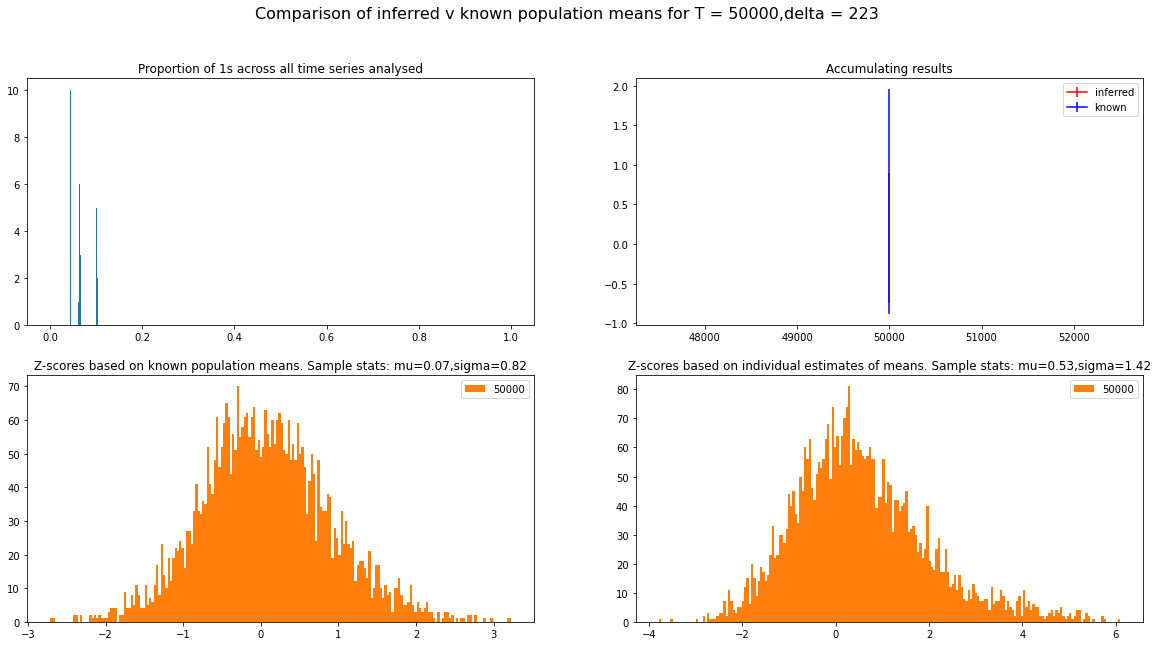

,T,Z score std dev (known means),Z score mean (known means),Z score std dev (inferred means),Z score mean (inferred means)
0,50000,0.82,0.072,1.418,0.533


Total of 0 empty time series found
Total of 0 time series calculations ignored (due to fewer than 4 events in one or both)


In [31]:
import pointwise_correlation as pc
import time_series_correlation as tc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize']=[20,10]

pc.SHORT_TIME_SERIES_Z_SCORES = []
pc.EMPTY_TIME_SERIES_COUNT = 0
# parameter dictionary 
params_dict = {
#                'T' : 1000                        # Length of each time series
                'n' : 5000,                      # How many time series in each population
               'Use external intialisation' : True,
#               'Use population means' : True, # Refers to whether correlation calculation is based on pre-determined or measured means

                'Use fixed means for setup' : True, # Refers to whether population(s) taken from given means or chai-squared dist
                'p1' : 0.1,
                'p2' : 0.5,            # mean occurences from which populations will be drawn 
    
#               'Test_mode' : False,
#                'dense' : True,  # only needed for time_series_correlation (obsolete class)
                'sparse': False # must be false - only dense time series can be analysed
                    } 

# if combinine multiple populations, these are the parameters for initialising.
multiple_population_params={'clusters':4,'mean lag range' : [10,50],'event probability range':[0.001,0.02],
                            'noise scaling' : 5,'pop_sizes':[30,20,10]}  
multiple_population_params['use fixed means']=params_dict['Use fixed means for setup']



# decide how to interpret the event probability range and mean lag range
# 'no interpretation' means the lists are passed as they are and their lengths must match the number of clusters
# 'given values only' means only the values given can be selected and these will be chosen randomly
# 'min max' means the values passed are the lower and higher limits and a uniform selection is made

#multiple_population_params['Method to interpret prob ranges']='no interpretation' # this passes the lists directly
multiple_population_params['Method to interpret prob ranges']=np.random.choice(['given values only','min max'])



lengths=[50000]  # Which lengths of time series to run the algorithm for

td_to_store,df=compare_inferred_and_known_means(version=pc,xs=lengths,params=params_dict,
                                    multiple_populations=True,multiple_pop_params=multiple_population_params,
                                    poisson_process=True,disjoint=False,verbose=True)
plt.show()
display(df)

short_ts_data = np.array(pc.SHORT_TIME_SERIES_Z_SCORES)
print("Total of {0} empty time series found".format(pc.EMPTY_TIME_SERIES_COUNT))
print("Total of {0} time series calculations ignored (due to fewer than 4 events in one or both)".format(len(short_ts_data)))

if len(short_ts_data):
    df = pd.DataFrame(list(np.transpose([[min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],list(short_ts_data[:,2])])),
                      columns = ['Length of short time series','Z score'])
    print("Z_scores for comparisons involving very short series averaged : {0}".format(np.mean(short_ts_data[:,2])))
    #plt.plot([min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],short_ts_data[:,2], 'x')
    #plt.show()

#print("Mean and sigma for the z scores for empty time series are {0} and {1}".format(np.mean(z_scores), np.std(z_scores)))
#plt.hist(z_scores)
#print(td_to_store)

In [5]:
import poisson_processes as pp
#default_params={'clusters':2,'event probability range':[0.1,0.2],'noise scaling' : 1,'pop_sizes':[5,10]}
def initialise_multiple_populations(length,params):

    #if not 'clusters' in params.keys():
    #    params=default_params
    #print(params.keys())
    clusters=params['clusters']
    mean_lag_range=params['mean lag range']
    event_probability_range=params['event probability range']
    noise_scaling=params['noise scaling']
    max_noise_prob=0.5
    use_fixed_means=params.get('use fixed means')
    method_for_p_range = params['Method to interpret prob ranges']
    
    pop_sizes=np.random.choice(params['pop_sizes'],size=clusters)  
    if clusters < 7:
        pop_names=np.random.choice(['Jill','Rosa','Flo','Luke','Owen','Tom','Elena'],size=clusters,replace=False)
    else:
        pop_names=np.random.choice(list(range(clusters)),size=clusters,replace=False)  
        pop_names=[str(p) for p in pop_names]

        
    # initialise event/noise probability and lag values
    if method_for_p_range == 'no interpretation':
        event_probs=event_probability_range
        noise_probs=[e*noise_scaling for e in event_probability_range]
        mean_lags=mean_lag_range
        
    elif method_for_p_range == 'min max':
        # set up allowable ranges for events,noise and lag
        ep_lower=event_probability_range[0]
        ep_higher=event_probability_range[-1]
        noise_lower=min(ep_lower*noise_scaling,max_noise_prob)
        noise_higher=min(ep_higher*noise_scaling,max_noise_prob)
        lag_lower=mean_lag_range[0]
        lag_upper=mean_lag_range[-1]
        
        event_probs=np.random.uniform(ep_lower,ep_higher,size=clusters)
        noise_probs=np.random.uniform(noise_lower,noise_higher,size=clusters)
        mean_lags=np.random.uniform(lag_lower,lag_upper,size=clusters)
        
    elif method_for_p_range == 'given values only':
        event_probs=np.random.choice(event_probability_range,size=clusters)
        noise_probs=np.random.choice([e*noise_scaling for e in event_probability_range],size=clusters)
        mean_lags=np.random.choice(mean_lag_range,size=clusters)
        
        






    

   
    mpp=pp.initialise_multiple_populations(length=length,sizes=pop_sizes,keys=pop_names,
                                            event_probs=event_probs,mean_lags=mean_lags,noise_probs=noise_probs,
                                           use_fixed_means=use_fixed_means,verbose=False)
        
    ts_obj1=mpp.randomly_mix_populations(pop_names)
    number=len(ts_obj1)        
    ts_obj2=[]
    return number,[ts_obj1,ts_obj2]

In [79]:
print(td_to_store.tweet_matrices[1][42].t_series)

[    2     8    14 ..., 19993 19995 19998]


In [68]:
a=np.array([[1],[2]])
print(a*2)

[[2]
 [4]]


In [ ]:
print()